# Table of Contents
 <p><div class="lev1"><a href="#Checking-derivatives"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checking derivatives</a></div><div class="lev1"><a href="#Optimizing-hyperparameters"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimizing hyperparameters</a></div><div class="lev1"><a href="#Updating-Cholesky"><span class="toc-item-num">3&nbsp;&nbsp;</span>Updating Cholesky</a></div>

In [1]:
Pkg.checkout("IJulia")

INFO: Checking out IJulia master...
INFO: Pulling IJulia latest master...
INFO: No packages to install, update or remove


In [1]:
using PyPlot, GaussianProcesses

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in @glue(::Any) at /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl:22
 in include_from_node1(::String) at ./loading.jl:426
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:357
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:164
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:138
 in (::IJulia.##25#31)() at ./task.jl:309
while loading /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl, in expression starting on line 29

Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
using GaussianProcesses

# Simulate example
n = 10
x = 2π * rand(n)
μ = 0.2
y = μ + sin(x) + 0.05*randn(n)
mConst = MeanConst(0.0) # constant mean
kern = SE(0.0,0.0)
logObsVar = -1.0
gp = GP(x,y,mConst,kern, logObsVar)      # Fit the GP

GaussianProcesses.update_mll_and_dmll!(gp)
prev_mLL=gp.mLL
prev_dmLL=gp.dmLL
prev_params=GaussianProcesses.get_params(gp)

dθ=[0.0, 1.0, 0.0, 0.0]*1e-4 # select mean parameters
GaussianProcesses.set_params!(gp, prev_params.+dθ)
GaussianProcesses.update_mll_and_dmll!(gp)

println("change in log likelihood: ", gp.mLL-prev_mLL)
println("expected change in log likelihood: ", dot(prev_dmLL, dθ))

change in log likelihood: 6.203283489192302e-5
expected change in log likelihood: 6.20464407607478e-5


# Checking derivatives

In [3]:
prev_mLL=gp.mLL
prev_dmLL=gp.dmLL

prev_params=GaussianProcesses.get_params(gp)

dθ=[1.0, 0.0, 1.0, 1.0]*1e-4 # select mean parameters
GaussianProcesses.set_params!(gp, prev_params.+dθ)
GaussianProcesses.update_mll_and_dmll!(gp)

println("change in log likelihood: ", gp.mLL-prev_mLL)
println("expected change in log likelihood: ", dot(prev_dmLL, dθ))

change in log likelihood: -0.0006049806432386617
expected change in log likelihood: -0.0006049604432612913


In [4]:
# Training data
n = 10
x = 2π * rand(n)
μ = 0.2
y = μ + sin(x) + 0.05*randn(n)

# Select mean and covariance function
mConst = MeanConst(0.0)                   # constant mean
kern = SE(0.0,0.0)                   # Squared exponential kernel with parameters
                                     # log(ℓ) = 0.0, log(σ) = 0.0

Type: GaussianProcesses.SEIso, Params: [0.0,0.0]


In [5]:
mZero = MeanZero()

Type: GaussianProcesses.MeanConst, Params: [0.0]


In [6]:
logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern, logObsNoise)      # Fit the GP

GP object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Input observations = 
[2.25252 2.91783 3.68829 3.73582 3.6427 3.55159 4.90618 5.77063 5.18178 2.6089]
  Output observations = [0.986694,0.452598,-0.327717,-0.412569,-0.168344,-0.193149,-0.77928,-0.247591,-0.67062,0.684838]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -5.369

In [9]:
GaussianProcesses.update_mll_and_dmll!(gp)
prev_mLL=gp.mLL
prev_dmLL=gp.dmLL

prev_params=GaussianProcesses.get_params(gp)

dθ=[0.0, 1.0, 0.0, 0.0]*1e-5
GaussianProcesses.set_params!(gp, prev_params.+dθ)

GaussianProcesses.get_params(gp).-prev_params

GaussianProcesses.update_mll_and_dmll!(gp)

println("change in log likelihood ", gp.mLL-prev_mLL)

println("expected change in log likelihood ", dot(prev_dmLL, dθ))

# reset parameter to what they were before
GaussianProcesses.set_params!(gp, prev_params)
GaussianProcesses.update_mll_and_dmll!(gp)

change in log likelihood 1.7506477680839794e-6
expected change in log likelihood 1.7507558394385948e-6


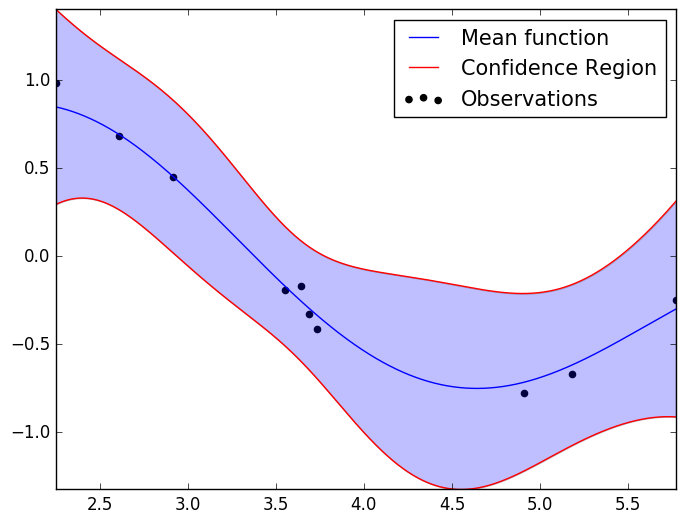

In [10]:
plot(gp)

# Optimizing hyperparameters

In [11]:
optimize!(gp)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.0,0.0,0.0,0.0]
 * Minimizer: [-2.937812294690533,0.49698042555472927, ...]
 * Minimum: -4.218159e+00
 * Iterations: 27
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 94
 * Gradient Calls: 67

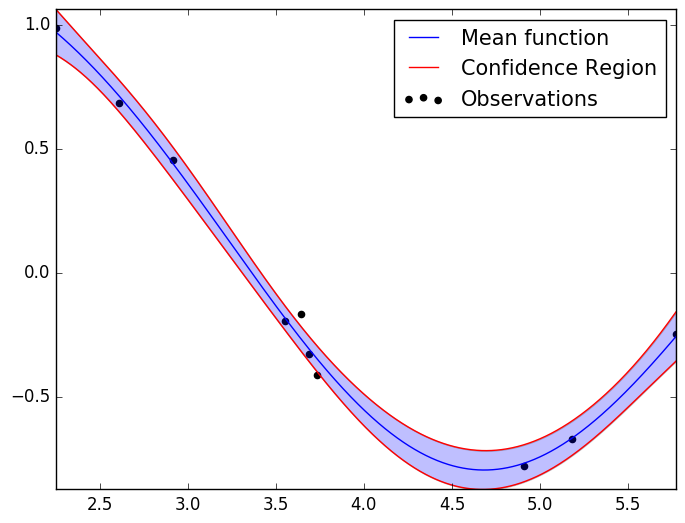

In [12]:
plot(gp)

# Updating Cholesky

In [13]:
import Base.LinAlg
LinAlg = Base.LinAlg

Base.LinAlg

In [14]:
gp.cK.chol

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.913113 0.843221 0.637998 0.622931 0.652317 0.680443 0.270502 0.107891 0.207514 0.890343; 0.0 0.350363 0.605695 0.614291 0.596529 0.575538 0.549183 0.323961 0.481349 0.190262; 0.0 0.0 0.244677 0.249893 0.217342 0.186268 0.565502 0.525708 0.579931 -0.014033; 0.0 0.0 0.0 0.0770229 0.0340759 0.0280456 0.118331 0.124589 0.126556 -0.00412689; 0.0 0.0 0.0 0.0 0.0633377 0.0181792 0.00259919 -0.0198377 -0.00533301 0.00205321; 0.0 0.0 0.0 0.0 0.0 0.0609609 -0.0506606 -0.0847147 -0.0656617 0.00599393; 0.0 0.0 0.0 0.0 0.0 0.0 0.350191 0.591728 0.438169 -0.00532378; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.259961 0.0725761 0.00906974; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0712726 0.000454089; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0670809]

In [19]:
?LinAlg.lowrankupdate

```
lowrankupdate(C::Cholesky, v::StridedVector) -> CC::Cholesky
```

Update a Cholesky factorization `C` with the vector `v`. If `A = C[:U]'C[:U]` then `CC = cholfact(C[:U]'C[:U] + v*v')` but the computation of `CC` only uses `O(n^2)` operations.


In [ ]:
methods(LinAlg.lowrankupdate)

In [21]:
gp.cK.chol

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.913113 0.843221 0.637998 0.622931 0.652317 0.680443 0.270502 0.107891 0.207514 0.890343; 0.0 0.350363 0.605695 0.614291 0.596529 0.575538 0.549183 0.323961 0.481349 0.190262; 0.0 0.0 0.244677 0.249893 0.217342 0.186268 0.565502 0.525708 0.579931 -0.014033; 0.0 0.0 0.0 0.0770229 0.0340759 0.0280456 0.118331 0.124589 0.126556 -0.00412689; 0.0 0.0 0.0 0.0 0.0633377 0.0181792 0.00259919 -0.0198377 -0.00533301 0.00205321; 0.0 0.0 0.0 0.0 0.0 0.0609609 -0.0506606 -0.0847147 -0.0656617 0.00599393; 0.0 0.0 0.0 0.0 0.0 0.0 0.350191 0.591728 0.438169 -0.00532378; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.259961 0.0725761 0.00906974; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0712726 0.000454089; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0670809]

In [20]:
LinAlg.lowrankupdate(gp.cK.chol, randn(n))

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[1.94818 -1.15196 0.255328 -0.362499 0.0104947 1.83406 0.932824 0.198348 0.197021 0.128225; 0.0 1.60451 0.704869 1.01 0.845458 -0.0722728 -0.0642524 0.0872294 0.23234 0.958739; 0.0 0.0 0.523632 0.473491 0.474741 0.622759 0.774501 0.521892 0.661112 -0.0238519; 0.0 0.0 0.0 0.0835596 0.0294411 -0.0200779 0.198364 0.238447 0.23551 -0.00507048; 0.0 0.0 0.0 0.0 0.0658168 0.0501362 -0.0427357 -0.0858455 -0.0686102 0.00235937; 0.0 0.0 0.0 0.0 0.0 0.126287 -0.165307 -0.243109 -0.227206 0.00359334; 0.0 0.0 0.0 0.0 0.0 0.0 0.351768 0.592601 0.440958 -0.00483994; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.260645 0.0717639 0.00865913; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0726005 0.00158574; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0673304]